# Valutazione *Informativeness* di una recensione  

Lo scopo di questa presentazione è quello di sviluppare un modello di NLP che sia in grado di determinare se una recensione sia informativa o meno. Una recensione informativa è una recensione che fornisce dettagli utili e specifici sull'esperienza dell'utente con un prodotto, servizio o luogo.  
In particolare, stiamo utilizzando un dataset che valuta il *sentiment* di  recensioni su Yelp.


Il primo passo fondamentale consiste nel preparare il dataset all'addestramento del modello, per cui svolgiamo prima di tutto operazioni di preprocessing.


In [ ]:
import pandas as pd
import numpy as np
import re
from textstat import flesch_reading_ease
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import wordnet
from huggingface_hub import hf_hub_download
from huggingface_hub import HfApi
import shutil
import os

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

try:
    nltk.data.find('taggers/averaged_perceptron_tagger')
except LookupError:
    nltk.download('averaged_perceptron_tagger')

try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

train_file = hf_hub_download(repo_id="GOAISI/webProject", filename="dataset/train.csv")
df = pd.read_csv(train_file)

# per il nostro scopo, non ci interessa il sentiment della recensione
df = df.drop(columns=['class_index'])

print(df.head(5))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Astolfo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                         review_text
0  Unfortunately, the frustration of being Dr. Go...
1  Been going to Dr. Goldberg for over 10 years. ...
2  I don't know what Dr. Goldberg was like before...
3  I'm writing this review to give you a heads up...
4  All the food is great here. But the best thing...


In [9]:
def clean_text(text):
    """rimozione di spazi ed accapi"""

    text = re.sub(r'\s+', ' ', text.strip())
    # Replace escaped newlines
    text = text.replace('\\n', ' ')
    return text

def extract_basic_features(text):
    """estrazione feature di base, come lunghezza, numero di frasi..."""
    cleaned_text = clean_text(text)

    char_count = len(cleaned_text)
    word_count = len(cleaned_text.split())
    sentence_count = len(sent_tokenize(cleaned_text))


    words = cleaned_text.split()
    avg_word_length = np.mean([len(word) for word in words]) if words else 0


    avg_sentence_length = word_count / sentence_count if sentence_count > 0 else 0

    return {
        'char_count': char_count,
        'word_count': word_count,
        'sentence_count': sentence_count,
        'avg_word_length': avg_word_length,
        'avg_sentence_length': avg_sentence_length
    }

df['review_text'] = df['review_text'].apply(clean_text)

basic_features = df['review_text'].apply(extract_basic_features)
basic_features_df = pd.DataFrame(basic_features.tolist())
df = pd.concat([df, basic_features_df], axis=1)

Proseguiamo ora a determinare se una recensione sia informativa o meno. Per fare ciò, valutiamo le seguenti proprietà:  
* **Lunghezza:** si suppone una recensione informativa sia composta da almeno 100 parole  
* **Specificità**: valutiamo la presenza di certi termini specifici all'interno della recensione, come ad esempio "prezzo", "attesa"...  
* **Qualità**: per qualità, intendiamo fattori come la facilità di lettura della frase (secondo la formula di Flesch), il rapporto tra termini emotivi e fattuali, eventuali suggerimenti per i lettori...  

A tutti questi fattori, viene assegnato un punteggio che va da 0 a 1; alla fine, il punteggio finale di ogni recensione sarà determinato dalla somma pesata:  

$$ totalScore = lengthScore*0,3+specifityScore*0,4+qualityScore*0,3 $$  

Una recensione sarà considerata informativa soltanto se ha uno score maggiore di 0.6

---  

### Calcolo *lengthScore*


In [10]:
def calculate_length_score(row):
    """Calcolo del punteggio in base alla lunghezza della recensione"""
    
    word_count = row['word_count']
    sentence_count = row['sentence_count']
    avg_sentence_length = row['avg_sentence_length']

    # una review troppo corta ottiene un punteggio basso
    # allo stesso modo, se è troppo lunga, ottiene una penalità
    if word_count < 10:
        word_score = 0.1
    elif word_count <= 30:
        word_score = 0.6
    elif word_count <= 100:
        word_score = 1.0
    elif word_count <= 200:
        word_score = 0.9
    else:
        word_score = 0.7

    # stesso di sopra ma con le frasi
    if sentence_count <= 1:
        sentence_score = 0.3
    elif sentence_count <= 3:
        sentence_score = 0.7
    elif sentence_count <= 6:
        sentence_score = 1.0
    else:
        sentence_score = 0.8

    # stesso ma con la lunghezza media delle frasi
    if avg_sentence_length < 5:
        sentence_length_score = 0.4
    elif avg_sentence_length <= 15:
        sentence_length_score = 1.0
    elif avg_sentence_length <= 25:
        sentence_length_score= 0.8
    else:
        sentence_length_score = 0.6

    # le sommo insieme dando più importanza al numero di parole
    length_score = (word_score * 0.4 + sentence_score * 0.3 + sentence_length_score * 0.3)
    return length_score


df['length_score'] = df.apply(calculate_length_score, axis=1)

---  

### Calcolo *SpecificityScore*

In [11]:
def calculate_specificity_score(text):
    """sputa fuori un punteggio in base a quanto è \"specifica\" la recensioe"""
    text_lower = text.lower()

    # cerchiamo all'interno di ogni recensione le seguenti parole e sinonimi associati
    # i sinonimi vengono trovati tramite wordnet
    service_words = [
        'service', 'staff', 'employee', 'manager', 'customer service', 'support', 'representative', 'clerk', 'cashier'
    ]
    product_words = [
        'product', 'item', 'selection', 'quality', 'variety', 'availability', 'stock', 'goods', 'merchandise'
    ]
    experience_words = [
        'experience', 'visit', 'appointment', 'session', 'event', 'activity', 'class', 'tour', 'trip'
    ]
    environment_words = [
        'environment', 'atmosphere', 'ambiance', 'clean', 'comfortable', 'space', 'location', 'facility', 'store', 'office', 'building'
    ]
    price_words = [
        'price', 'cost', 'expensive', 'cheap', 'value', 'money', 'dollar', '$', 'budget', 'fee', 'rate', 'charge'
    ]
    time_words = [
        'wait', 'time', 'quick', 'slow', 'minutes', 'hours', 'fast', 'prompt', 'delay', 'schedule', 'appointment'
    ]


    def get_synonyms(word):
        synonyms = set()
        for syn in wordnet.synsets(word):
            for lemma in syn.lemmas():
                synonym = lemma.name().replace('_', ' ').lower()
                if synonym != word:
                    synonyms.add(synonym)
        return synonyms


    def expand_with_synonyms(word_list):
        expanded = set(word_list)
        for word in word_list:
            expanded.update(get_synonyms(word))
        return expanded


    service_words = list(expand_with_synonyms(service_words))
    product_words = list(expand_with_synonyms(product_words))
    experience_words = list(expand_with_synonyms(experience_words))
    environment_words = list(expand_with_synonyms(environment_words))
    price_words = list(expand_with_synonyms(price_words))
    time_words = list(expand_with_synonyms(time_words))

    all_aspect_words = (
        service_words + product_words + experience_words +
        environment_words + price_words + time_words
    )

    # contiamo quante volte è presente ogni parola sopracitata nella recensione
    aspect_mentions = sum(1 for word in all_aspect_words if word in text_lower)

    # il numero totale viene diviso per 10, se risulta maggiore di 1 viene assegnato 1
    aspect_score = min(aspect_mentions / 10, 1.0)


    # eseguiamo la stessa operazione di sopra ma per altri termini
    descriptive_words = [
        'excellent', 'terrible', 'amazing', 'awful', 'outstanding', 'horrible', 'fantastic', 'disappointing',
        'perfect', 'worst', 'best', 'incredible', 'friendly', 'rude', 'helpful', 'unprofessional', 'attentive',
        'slow', 'quick', 'clean', 'dirty', 'comfortable', 'uncomfortable', 'professional', 'efficient', 'knowledgeable'
    ]

    descriptive_words = list(expand_with_synonyms(descriptive_words))

    descriptive_count = sum(1 for word in descriptive_words if word in text_lower)
    descriptive_score = min(descriptive_count / 10, 1.0)

    # stesso di sopra ma utilizzando termini più specifici e numeri menzionati
    numbers = len(re.findall(r'\b\d+\b', text))
    specific_places = len(re.findall(
        r'\b(table|booth|bar|counter|window|parking|bathroom|desk|room|section|area|floor|entrance|exit|checkout|register)\b',
        text_lower))
    specific_items = len(re.findall(
        r'\b(burger|pizza|salad|coffee|product|item|service|package|deal|offer|appointment|class|session|ticket|order)\b',
        text_lower))

    # visto che con molta probabilità questi termini saranno meno comuni, qui dividiamo per 5
    details_score = min((numbers + specific_places + specific_items) / 5, 1.0)

    # termini comparativi
    comparison_words = ['better', 'worse', 'compared', 'than', 'like', 'similar', 'different', 'previous']
    comparison_words = list(expand_with_synonyms(comparison_words))
    comparison_count = sum(1 for word in comparison_words if word in text_lower)
    # qui divido per 3 perchè sono meno parole
    comparison_score = min(comparison_count / 3, 1.0)

    # li metto tutti insieme
    # do meno importanza ai termini specifici e comparativi in quanto supponiamo saranno meno degli altri
    specificity_score = (aspect_score * 0.4 + descriptive_score * 0.3 +
                        details_score * 0.2 + comparison_score * 0.1)

    return {
        'aspect_score': aspect_score,
        'descriptive_score': descriptive_score,
        'details_score': details_score,
        'comparison_score': comparison_score,
        'specificity_score': specificity_score
    }

specificity_features = df['review_text'].apply(calculate_specificity_score)
specificity_df = pd.DataFrame(specificity_features.tolist())

df = pd.concat([df, specificity_df], axis=1)

---  
### Calcolo *qualityScore*

In [12]:
def calculate_quality_score(text):
    """Calcola un punteggio di qualità per la recensione"""

    # facilità di lettura secondo la formula di Flesch
    # https://it.wikipedia.org/wiki/Formula_di_Flesch
    try:
        reading_ease = flesch_reading_ease(text)
        if reading_ease < 30:
            readability_score = 0.3
        elif reading_ease < 60:
            readability_score = 0.7
        elif reading_ease <= 70:
            readability_score = 1.0
        elif reading_ease <= 90:
            readability_score = 0.8
        else:
            readability_score = 0.5
    except:
        readability_score = 0.5  # a volte fallisce

    text_lower = text.lower()

    # rapporto tra contenuti emotivi e fattuali
    emotional_words = ['love', 'hate', 'amazing', 'terrible', 'awesome', 'awful', 'fantastic',
                      'horrible', 'wonderful', 'disgusting', 'perfect', 'worst', 'best']
    factual_words = ['because', 'since', 'due to', 'reason', 'caused', 'result', 'therefore',
                    'however', 'although', 'despite', 'while', 'whereas', 'specifically']

    # sinonimi da WordNet
    def get_synonyms(word):
        synonyms = set()
        for syn in wordnet.synsets(word):
            for lemma in syn.lemmas():
                synonym = lemma.name().replace('_', ' ').lower()
                if synonym != word:
                    synonyms.add(synonym)
        return synonyms

    #wrapper di sopra per espandere le liste
    def expand_with_synonyms(word_list):
        expanded = set(word_list)
        for word in word_list:
            expanded.update(get_synonyms(word))
        return expanded

    emotional_words = list(expand_with_synonyms(emotional_words))
    factual_words = list(expand_with_synonyms(factual_words))

    emotional_count = sum(1 for word in emotional_words if word in text_lower)
    factual_count = sum(1 for word in factual_words if word in text_lower)

    total_indicators = emotional_count + factual_count

    # se è zero gli assegnho
    if total_indicators == 0:
        balance_score = 0.5
    else:
        # ratio tra fattuali e emotivi
        factual_ratio = factual_count / total_indicators
        if factual_ratio >= 0.4:  # naturalmente più è alto meglio è
            balance_score = 1.0
        elif factual_ratio >= 0.2:
            balance_score = 0.8
        else:
            balance_score = 0.6

    # Grammar and structure indicators
    qe_marks = text.count('!') + text.count('?')
    punctuation_variety = len(set([c for c in text if c in '.,!?;:']))

    # valuto la varietà di punteggiatura
    # se sono più di 6 punti esclamativi o interrogativi, la struttura è penalizzata
    if qe_marks > 6:
        structure_score = 0.6
    elif punctuation_variety >= 3:
        structure_score = 1.0
    elif punctuation_variety >= 2:
        structure_score = 0.8
    else:
        structure_score = 0.5

    # suggerimenti per altri
    actionable_words = ['recommend', 'suggest', 'avoid', 'try', 'should', 'would', 'will',
                       'go back', 'return', 'visit', 'skip', 'worth', 'not worth']

    actionable_words = list(expand_with_synonyms(actionable_words))

    actionable_count = sum(1 for word in actionable_words if word in text_lower)
    actionable_score = min(actionable_count / 2, 1.0)

    # somma pesata
    quality_score = (readability_score * 0.3 + balance_score * 0.3 +
                    structure_score * 0.2 + actionable_score * 0.2)

    # restituisco tutti gli score nel caso servano in futuro
    return {
        'readability_score': readability_score,
        'balance_score': balance_score,
        'structure_score': structure_score,
        'actionable_score': actionable_score,
        'quality_score': quality_score
    }

# Calculate quality scores
quality_features = df['review_text'].apply(calculate_quality_score)
quality_df = pd.DataFrame(quality_features.tolist())

# Add to main dataframe
df = pd.concat([df, quality_df], axis=1)

---  
### Valutazione finale  

Sommiamo tutti i punteggi calcolati in precedenza, poi classifichiamo una recensione come informativa soltanto se il punteggio finale ha un valore superiore a 0.6. Carichiamo il dataset processato su una repo di hugging face.

In [ ]:
df['combined_score'] = (df['length_score'] * 0.3 +
                       df['specificity_score'] * 0.4 +
                       df['quality_score'] * 0.3)

# codifichiamo le recensioni come informative o meno in maniera binaria
df['is_informative'] = df['combined_score'] >= 0.6
print(df['is_informative'].value_counts())

os.makedirs("temp", exist_ok=True)
save_df = df[['review_text', 'is_informative', 'combined_score']]
save_df.to_csv("temp/train_informative.csv", index=False)

api = HfApi()
api.upload_file(
    path_or_fileobj="temp/train_informative.csv",
    path_in_repo="dataset/train_informative.csv",
    repo_id="GOAISI/webProject",
    repo_type="model",
    commit_message="Update train_informative.csv with informativeness labels"
)

shutil.rmtree("temp", ignore_errors=True)


is_informative
True     489886
False     70114
Name: count, dtype: int64


In [26]:
print("Informative reviews:")
temp = df[df['is_informative'] == True]['review_text'].sample(10, random_state=1).to_list()
for x in temp:
    print(x)
    print(' ')

print('====================================')

print("\nNot informative reviews:")
temp = df[df['is_informative'] == False]['review_text'].sample(10, random_state=1).to_list()
for x in temp:
    print(x)
    print(' ')

Informative reviews:
I only stopped in for a quick bite and a drink with a friend. Got the sum thing sum thing roll, Lychee cocktail and a corn soup taster before my sushi roll came out. I had a really nice little snack there. I'd try it again.
 
What a beautiful restaurant! It's situated on the top floor of THE Hotel and has the most breathtaking views of the city. The restaurant boasts all white decor and is oh so chic.  We had a table next to a window so we had a phenomenal view.  There were 8 of us.  I ordered a glass of Pinot Grigio, we started off with shoestring fries, a Caesar Salad and I had the Potato Gnocchi for my entree.  My wine was tasty, the shoestring fries were addicting and I was in love with my Caesar Salad. The Potato Gnocchi was just okay for me...there was something missing there. The service was good, not great. This was a really gorgeous restaurant...but not too many veggie options so I probably wouldn't go back again.  The bill came out to $70/person with tax 

Le stesse operazioni sono state svolte anche sul dataset di testing. Per l'addestramento, non useremo l'interezza del dataset ma soltanto 9000 entries, divise equamente tra recensioni informative e non. Il numero scelto è una limitazione di Google Colab.

In [ ]:
def balance_dataset(df):
    
    class_0 = df[df['is_informative'] == 0].sample(n=4500, random_state=42)
    class_1 = df[df['is_informative'] == 1].sample(n=4500, random_state=42)
    balanced_df = pd.concat([class_0, class_1]).sample(frac=1, random_state=42).reset_index(drop=True)
    
    return balanced_df

repo = "GOAISI/webProject"

csv_path = hf_hub_download(repo_id=repo, filename="dataset/train_informativeTOT.csv")
df= pd.read_csv(csv_path)
df = balance_dataset(df)

print(df['is_informative'].value_counts())

is_informative
True     4500
False    4500
Name: count, dtype: int64


---  
## Addestramento modelli ML  

Prima di procedere all'addestramento del modello utilizzando BERT, vediamo come si comportano modelli di machine learning più elementari.

Addestramento di modelli ml

Random Forest:
Accuracy: 0.9104
Classification Report:
              precision    recall  f1-score   support

       False       0.87      0.97      0.92      1389
        True       0.96      0.85      0.90      1311

    accuracy                           0.91      2700
   macro avg       0.92      0.91      0.91      2700
weighted avg       0.92      0.91      0.91      2700


Naive Bayes:
Accuracy: 0.5985
Classification Report:
              precision    recall  f1-score   support

       False       0.97      0.23      0.37      1389
        True       0.55      0.99      0.71      1311

    accuracy                           0.60      2700
   macro avg       0.76      0.61      0.54      2700
weighted avg       0.77      0.60      0.53      2700


Linear SVM:
Accuracy: 0.9004
Classification Report:
              precision    recall  f1-score   support

       False       0.90      0.91      0.90      1389
        True       0.90      0.89      0.90   

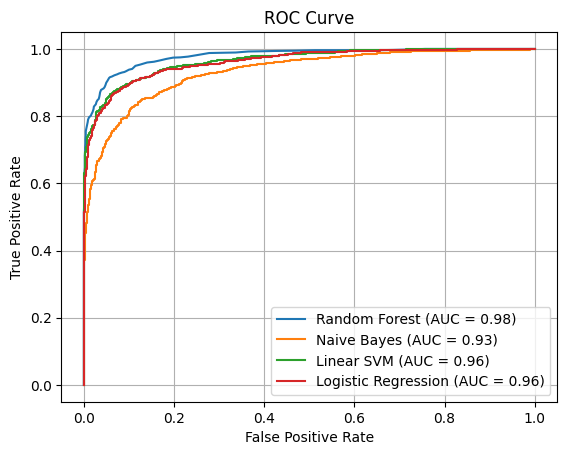

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

X = df['review_text']
y = df['is_informative']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier(random_state=42))
])

pipeline2 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

pipeline3 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC(random_state=42))
])

pipeline4 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=42, max_iter=1000))
])

pipelines = {
    'Random Forest': pipeline,
    'Naive Bayes': pipeline2,
    'Linear SVM': pipeline3,
    'Logistic Regression': pipeline4
}

print("Addestramento di modelli ml")

results = {}
for name, pipe in pipelines.items():
    
    pipe.fit(X_train, y_train)
    
    
    y_pred = pipe.predict(X_test)
    
    
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    
    print(f"\n{name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    
    if hasattr(pipe.named_steps['clf'], "predict_proba"):
        y_score = pipe.predict_proba(X_test)[:, 1]
    elif hasattr(pipe.named_steps['clf'], "decision_function"):
        y_score = pipe.decision_function(X_test)
    else:
        y_score = y_pred

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)

plt.show()



All'apparenza, i modelli si comportano in maniera accettabile. Proviamo ora a predirre la classe delle recensioni presenti sul dataset di testing, di 5000 entry.

In [22]:
repo = "GOAISI/webProject"
csv_path = hf_hub_download(repo_id=repo, filename="dataset/test_informative.csv")
df_test = pd.read_csv(csv_path)

for name, pipe in pipelines.items():
    y_pred_test = pipe.predict(df_test['review_text'])
    print(f"\n{name} - Classification Report on Test Set:")
    print(classification_report(df_test['is_informative'], y_pred_test))


Random Forest - Classification Report on Test Set:
              precision    recall  f1-score   support

       False       0.46      0.98      0.63       643
        True       1.00      0.83      0.90      4357

    accuracy                           0.85      5000
   macro avg       0.73      0.91      0.77      5000
weighted avg       0.93      0.85      0.87      5000


Naive Bayes - Classification Report on Test Set:
              precision    recall  f1-score   support

       False       0.90      0.22      0.35       643
        True       0.90      1.00      0.94      4357

    accuracy                           0.90      5000
   macro avg       0.90      0.61      0.65      5000
weighted avg       0.90      0.90      0.87      5000


Linear SVM - Classification Report on Test Set:
              precision    recall  f1-score   support

       False       0.54      0.91      0.68       643
        True       0.99      0.89      0.93      4357

    accuracy                   

Notiamo che, sul dataset di testing, i modelli sono molto meno precisi a prevedere le recensioni non informative.  

## Classificazione utilizzando BERT  

Procediamo ora a addestrare BERT per vedere se si comporta meglio dei modelli utilizzati in precedenza.

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset
from transformers import (
    BertTokenizer, 
    BertForSequenceClassification,
    Trainer, 
    TrainingArguments
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)

#questo serve a vedere se la GPU è disponibile
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Uso: {device}")
print(f"PyTorch version: {torch.__version__}")

# questa classe viene utilizzata per semplificare la gestione del dataset
# il trainer chiamerà in automatico il metodo __getitem__ per ottenere gli input
# il testo viene tokenizzato allora
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

def compute_metrics(eval_pred):
    """Compute metrics for evaluation"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(labels, predictions)
    
    return {'accuracy': accuracy}

X = df['review_text'].values
y = df['is_informative'].values


X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)


print(f"  Training: {len(X_train)} samples")
print(f"  Validation: {len(X_val)} samples")
print(f"  Test: {len(X_test)} samples")


model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)


model.to(device)

train_dataset = ReviewDataset(X_train, y_train, tokenizer)
val_dataset = ReviewDataset(X_val, y_val, tokenizer)
test_dataset = ReviewDataset(X_test, y_test, tokenizer)

training_args = TrainingArguments(
    output_dir='./bert_model_temp',
    num_train_epochs=2,
    per_device_train_batch_size=4,  
    per_device_eval_batch_size=4,   
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy='steps',
    eval_steps=100,
    save_strategy='steps',
    save_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    report_to=None,
    seed=42,
    dataloader_pin_memory=False,
    remove_unused_columns=False,
    fp16=False,
    dataloader_num_workers=0
)

print("creazione trainer")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

print("addestramento")

training_output = trainer.train()
print(f"finito: {training_output}")

test_results = trainer.evaluate(test_dataset)
print(f"valutazione test set: {test_results}")

Il modello è stato già addestrato su Google Colab utilizzando il codice sopra, procediamo soltanto a testarlo tramite lo stesso dataset di testing utilizzato in precedenza.

In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np
from sklearn.metrics import confusion_matrix

tokenizer = BertTokenizer.from_pretrained(repo)
model = BertForSequenceClassification.from_pretrained(repo)

def predict_informativeness(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = logits.argmax(dim=1).item()
    return predicted_class


df = pd.read_csv(csv_path)


y_true = df['is_informative'].tolist()
y_pred = [predict_informativeness(text) for text in df['review_text']]


cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

report = classification_report(y_true, y_pred, target_names=["Not Informative", "Informative"])
print(report)



def predict_proba_informativeness(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)
    probs = outputs.logits.softmax(dim=1)
    return probs[0, 1].item()

y_score = [predict_proba_informativeness(text) for text in df['review_text']]

fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"BERT (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - BERT")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()